In [1]:
import itertools
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import *
from models import *
from sampler import *
from utils import *

imb_type = 'exp'
imb_factor = 0.01
noise_mode = 'imb'
noise_ratio = 0.0
resample_ratio = 1.0
rand_number = 0

batch_size = 128
lr = 0.1
num_epochs = 8
num_epochs_retrain = 4
print_freq = 100
num_workers = 0
gpu = 0

seed = 0
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
# load data
transform = transforms.ToTensor()
train_dataset = MNIST_LT(root='./data', imb_type=imb_type, imb_factor=imb_factor, noise_mode=noise_mode, noise_ratio=noise_ratio, resample_ratio=resample_ratio,
                         rand_number=rand_number, train=True, download=True, transform=transform)
test_dataset = MNIST_LT(root='./data', train=False, download=True, transform=transform)

num_classes = train_dataset.cls_num
cls_num_list = train_dataset.get_cls_num_list()
print('cls num list:', cls_num_list)
inversed_freq = 1.0 / torch.Tensor(cls_num_list).cuda(gpu)

clean_targets = np.array(train_dataset.clean_targets)
targets = np.array(train_dataset.targets)
print('noise ratio:', (clean_targets != targets).mean())

cls num list: [5923, 3596, 2156, 1292, 774, 464, 278, 166, 100, 60]
noise ratio: 0.0


In [3]:
# torch.manual_seed(0)
model = LeNet2_FE()
classifier1 = Classifier(2, 10)
# torch.seed()
model = model.cuda(gpu)
classifier1 = classifier1.cuda(gpu)

# sampler, criterion = None, nn.CrossEntropyLoss().cuda(gpu)
sampler, criterion = ClassAwareSampler(train_dataset), nn.CrossEntropyLoss().cuda(gpu)
# sampler, criterion = None, nn.CrossEntropyLoss(weight=inversed_freq).cuda(gpu)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, shuffle=(sampler is None), num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=num_workers, pin_memory=True)

optimizer = torch.optim.SGD(itertools.chain(model.parameters(), classifier1.parameters()), lr=lr)

for epoch in range(num_epochs):
    # training
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')

    # switch to train mode
    model.train()
    classifier1.train()

    for i, (images, target) in enumerate(train_loader):
        images = images.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)
        
        feat = model(images)
        output = classifier1(feat)
        loss = F.cross_entropy(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % print_freq == 0:
            out = ('Epoch: [{0}][{1}/{2}]\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                   'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                   'Prec@5 {top5.val:.3f} ({top5.avg:.3f})').format(
                epoch, i, len(train_loader), loss=losses, top1=top1, top5=top5)
            # print(out)

    # test
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.3f')
    top5 = AverageMeter('Acc@5', ':6.3f')
    
    # switch to evaluate mode
    model.eval()
    classifier1.eval()

    test_preds = []
    test_targets = []
    
    with torch.no_grad():
        for i, (images, target) in enumerate(test_loader):
            images = images.cuda(gpu, non_blocking=True)
            target = target.cuda(gpu, non_blocking=True)
            
            # compute output
            feat = model(images)
            output = classifier1(feat)
            _, predicted = output.max(1)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))
            
            _, pred = torch.max(output, 1)
            test_preds.extend(pred.cpu())
            test_targets.extend(target.cpu())

            if i % print_freq == 0:
                out = ('Test: [{0}/{1}]\t'
                       'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                       'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                       'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                    i, len(test_loader), loss=losses, top1=top1, top5=top5))
                # print(out)

        cf = confusion_matrix(test_targets, test_preds).astype(float)
        cls_cnt = cf.sum(axis=1)
        cls_hit = np.diag(cf)
        cls_acc = cls_hit / cls_cnt

        out_acc = ('Results: Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f} Loss {loss.avg:.5f}'
                .format(top1=top1, top5=top5, loss=losses))
        out_cls_acc = 'Class Accuracy: %s' % (np.array2string(cls_acc, separator=',', formatter={'float_kind':lambda x: "%.3f" % x}))
        print(out_acc, end='   ')
        print(out_cls_acc)
    
    # if epoch > int(num_epochs * 0.8):
    #     _lr = lr * 0.01
    # elif epoch > int(num_epochs * 0.6):
    #     _lr = lr * 0.1
    # else:
    #     _lr = lr
    
    _lr = 0.5 * lr * (1 + math.cos((epoch + 1) / num_epochs * 3.1415926535))

    for param_group in optimizer.param_groups:
        param_group['lr'] = _lr


Results: Prec@1 90.660 Prec@5 98.790 Loss 0.25590   Class Accuracy: [0.959,0.985,0.966,0.881,0.979,0.893,0.930,0.870,0.775,0.816]
Results: Prec@1 91.490 Prec@5 98.630 Loss 0.12437   Class Accuracy: [0.991,0.983,0.953,0.943,0.979,0.904,0.918,0.916,0.747,0.803]
Results: Prec@1 90.020 Prec@5 98.680 Loss 0.08238   Class Accuracy: [0.987,0.990,0.979,0.954,0.979,0.934,0.946,0.869,0.727,0.630]
Results: Prec@1 91.260 Prec@5 98.870 Loss 0.00208   Class Accuracy: [0.993,0.994,0.983,0.967,0.979,0.923,0.914,0.892,0.745,0.724]
Results: Prec@1 90.970 Prec@5 98.860 Loss 0.00615   Class Accuracy: [0.995,0.994,0.975,0.970,0.975,0.919,0.907,0.886,0.752,0.713]
Results: Prec@1 90.850 Prec@5 98.870 Loss 0.00146   Class Accuracy: [0.995,0.993,0.975,0.968,0.979,0.923,0.908,0.885,0.752,0.697]
Results: Prec@1 90.860 Prec@5 98.870 Loss 0.00163   Class Accuracy: [0.995,0.993,0.975,0.969,0.978,0.920,0.907,0.888,0.752,0.698]
Results: Prec@1 90.830 Prec@5 98.880 Loss 0.00224   Class Accuracy: [0.995,0.993,0.975,0.9

In [4]:
cls_acc[0:3].mean(), cls_acc[3:7].mean(), cls_acc[7:10].mean()

(0.9875519008614271, 0.9441168879604558, 0.7774971273870328)

In [5]:
sampler, criterion = ClassAwareSampler(train_dataset), nn.CrossEntropyLoss().cuda(gpu)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, shuffle=(sampler is None), num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=num_workers, pin_memory=True)

classifier2 = copy.deepcopy(classifier1)
classifier2 = classifier2.cuda(gpu)

optimizer = torch.optim.SGD(classifier2.parameters(), lr=lr)

for epoch in range(num_epochs_retrain):
    # training
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')

    # switch to train mode
    model.eval()
    classifier2.train()

    for i, (images, target) in enumerate(train_loader):
        images = images.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)
        
        with torch.no_grad():
            feat = model(images)
        output = classifier2(feat.detach())
        loss = F.cross_entropy(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % print_freq == 0:
            out = ('Epoch: [{0}][{1}/{2}]\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                   'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                   'Prec@5 {top5.val:.3f} ({top5.avg:.3f})').format(
                epoch, i, len(train_loader), loss=losses, top1=top1, top5=top5)
            # print(out)

    # test
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.3f')
    top5 = AverageMeter('Acc@5', ':6.3f')
    
    # switch to evaluate mode
    model.eval()
    classifier2.eval()

    test_preds = []
    test_targets = []
    
    with torch.no_grad():
        for i, (images, target) in enumerate(test_loader):
            images = images.cuda(gpu, non_blocking=True)
            target = target.cuda(gpu, non_blocking=True)
            
            # compute output
            feat = model(images)
            output = classifier2(feat)
            _, predicted = output.max(1)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))
            
            _, pred = torch.max(output, 1)
            test_preds.extend(pred.cpu())
            test_targets.extend(target.cpu())

            if i % print_freq == 0:
                out = ('Test: [{0}/{1}]\t'
                       'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                       'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                       'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                    i, len(test_loader), loss=losses, top1=top1, top5=top5))
                # print(out)

        cf = confusion_matrix(test_targets, test_preds).astype(float)
        cls_cnt = cf.sum(axis=1)
        cls_hit = np.diag(cf)
        cls_acc = cls_hit / cls_cnt

        out_acc = ('Results: Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f} Loss {loss.avg:.5f}'
                .format(top1=top1, top5=top5, loss=losses))
        out_cls_acc = 'Class Accuracy: %s' % (np.array2string(cls_acc, separator=',', formatter={'float_kind':lambda x: "%.3f" % x}))
        print(out_acc, end='   ')
        print(out_cls_acc)
    
    # if epoch > int(num_epochs * 0.8):
    #     _lr = lr * 0.01
    # elif epoch > int(num_epochs * 0.6):
    #     _lr = lr * 0.1
    # else:
    #     _lr = lr
    
    _lr = 0.5 * lr * (1 + math.cos((epoch + 1) / num_epochs * 3.1415926535))

    for param_group in optimizer.param_groups:
        param_group['lr'] = _lr


Results: Prec@1 90.810 Prec@5 98.880 Loss 0.00350   Class Accuracy: [0.995,0.993,0.975,0.969,0.979,0.920,0.909,0.884,0.753,0.693]
Results: Prec@1 90.730 Prec@5 98.880 Loss 0.00076   Class Accuracy: [0.995,0.993,0.974,0.970,0.977,0.920,0.909,0.884,0.752,0.688]
Results: Prec@1 90.800 Prec@5 98.880 Loss 0.00139   Class Accuracy: [0.995,0.993,0.974,0.970,0.979,0.920,0.907,0.888,0.751,0.692]
Results: Prec@1 90.810 Prec@5 98.880 Loss 0.00164   Class Accuracy: [0.995,0.993,0.975,0.969,0.979,0.920,0.907,0.885,0.753,0.694]


In [6]:
torch.save({'state_dict_model': model.state_dict(),
            'state_dict_classifier1': classifier1.state_dict(),
            'state_dict_classifier2': classifier2.state_dict(),
}, 'checkpoints/mnist_lt_rs.pth')

In [3]:
model = LeNet2_FE()
classifier1 = Classifier(2, 10)
classifier2 = Classifier(2, 10)
model = model.cuda(gpu)
classifier1 = classifier1.cuda(gpu)
classifier2 = classifier2.cuda(gpu)

checkpoint = torch.load('checkpoints/mnist_lt_rs.pth')
model.load_state_dict(checkpoint['state_dict_model'])
classifier1.load_state_dict(checkpoint['state_dict_classifier1'])
classifier2.load_state_dict(checkpoint['state_dict_classifier2'])

<All keys matched successfully>

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=num_workers, pin_memory=True)

model.eval()
# classifier1.eval()
# classifier2.eval()
train_feats = []
train_targets = []
with torch.no_grad():
    for images, target in train_loader:
        images = images.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)
        feat = model(images)
        train_feats.extend(feat.cpu())
        train_targets.extend(target.cpu())
train_feats = torch.stack(train_feats)
train_targets = torch.stack(train_targets)

test_feats = []
test_targets = []
with torch.no_grad():
    for images, target in test_loader:
        images = images.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)
        feat = model(images)
        test_feats.extend(feat.cpu())
        test_targets.extend(target.cpu())
test_feats = torch.stack(test_feats)
test_targets = torch.stack(test_targets)

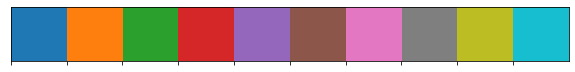

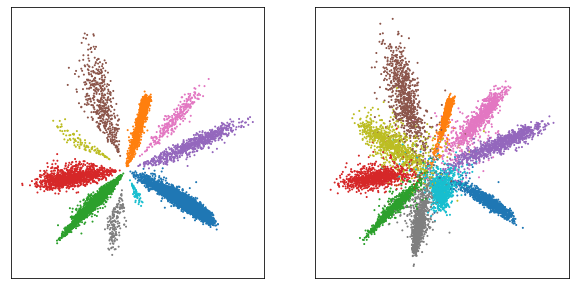

In [5]:
plt.rcParams['font.family'] = 'Times New Roman'
colors = sns.color_palette()
colors = np.array(colors)
sns.palplot(colors)

'''
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax0.set_aspect(1)
ax1.set_aspect(1)
# plt.xlim(-16, 16)
# plt.ylim(-16, 16)
ax0.scatter(train_feats[:,0], train_feats[:,1], s=1, color=colors[train_targets])
ax1.scatter(test_feats[:,0], test_feats[:,1], s=1, color=colors[test_targets])
# weights = classifier1.weight.detach().cpu() # CE
# weights = classifier2.weight.detach().cpu() # cRT
# for i in range(num_classes):
#     ax0.arrow(0, 0, weights[i][0], weights[i][1], color=colors[i], width=0.1, head_width=0.5)
#     ax1.arrow(0, 0, weights[i][0], weights[i][1], color=colors[i], width=0.1, head_width=0.5)
plt.show()
'''

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax0.scatter(train_feats[:,0], train_feats[:,1], s=1, color=colors[train_targets])
ax1.scatter(test_feats[:,0], test_feats[:,1], s=1, color=colors[test_targets])
# ax0.set_title('Training Set', fontsize=26)
# ax1.set_title('Test Set', fontsize=26)
ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
# plt.show()
plt.grid()
plt.savefig('mnist_rs.png', dpi=300, bbox_inches='tight')